# aenet-gpr ASE Calculator Tutorial

This tutorial demonstrates how to use a trained `aenet-gpr` model as an [ASE-calculator](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html) to compute the **energy** and **forces** of an `Atoms` object.

By integrating `aenet-gpr` with `ASE`, you can seamlessly use GPR potentials in your atomistic simulations, just like any other `ASE calculators`.

## Key Features:
- Construct a pre-trained `aenet-gpr` model
- Attach it to an `Atoms` object as a calculator
- Compute total energy and atomic forces

In [1]:
try:
    import torch
    print("successfully imported torch")
    print(torch.__version__)
except ImportError:
    !! pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cpu
    print("completed installing torch")

successfully imported torch
2.6.0+cu124


In [2]:
try:
    import numpy as np
    print("successfully imported numpy")
    print(np.__version__)
except ImportError:
    !! pip install numpy --user --upgrade
    print("completed installing numpy")

successfully imported numpy
1.26.4


In [3]:
try:
    from matplotlib import pyplot as plt
    print("successfully imported matplotlib")
except ImportError:
    !! pip install matplotlib --user --upgrade
    print("completed installing matplotlib")

successfully imported matplotlib


In [4]:
!! pip install aenet-gpr --user --upgrade
print("completed installing aenet-gpr")

! pip show aenet-gpr

completed installing aenet-gpr
Name: aenet-gpr
Version: 2.6.5
Summary: Atomistic simulation tools based on Gaussian Processes Regression
Home-page: https://github.com/atomisticnet/aenet-gpr
Author: In Won Yeu
Author-email: iy2185@columbia.edu
License: MPL-2.0
Location: /data/home/iy2185/.local/lib/python3.12/site-packages
Requires: ase
Required-by: 


In [5]:
import os, sys, site
sys.path.append(site.USER_SITE)

import aenet_gpr
print(aenet_gpr.__version__)

from aenet_gpr.util import ReferenceData
from aenet_gpr.inout import io_train_parameters

2.6.5


# 1. Read reference training/test data from xsf files

We are using train/test HSE06 data of EC dimer prepared in `aenet-gpr/example/2_EC-EC/`

In [6]:
import os.path

! rm -rf 2_EC-EC
! mkdir 2_EC-EC
    
if os.path.isfile("../example/2_EC-EC/train_set_tutorial.zip"):
    ! unzip -oq ../example/2_EC-EC/train_set_tutorial.zip -d ./2_EC-EC/
    print("number of train data:")
    ! find ./2_EC-EC/train_set_tutorial/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/2_EC-EC/train_set_tutorial.zip
    ! unzip -oq train_set_tutorial.zip -d ./2_EC-EC/
    ! rm train_set_tutorial.zip
    print("number of train data:")
    ! find ./2_EC-EC/train_set_tutorial/ -type f | wc -l

--2025-10-19 17:35:49--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/2_EC-EC/train_set_tutorial.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/2_EC-EC/train_set_tutorial.zip [following]
--2025-10-19 17:35:49--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/2_EC-EC/train_set_tutorial.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101063 (99K) [application/zip]
Saving to: ‘train_set_tutorial.zip’

train_set_tutorial. 100%[===================>]  98.69K  --.-KB/s    in 0.002s  

2025

In [7]:
if os.path.isfile("../example/2_EC-EC/test_set_tutorial.zip"):
    ! unzip -oq ../example/2_EC-EC/test_set_tutorial.zip -d ./2_EC-EC/
    print("number of test data:")
    ! find ./2_EC-EC/test_set_tutorial/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/2_EC-EC/test_set_tutorial.zip
    ! unzip -oq test_set_tutorial.zip -d ./2_EC-EC/
    ! rm test_set_tutorial.zip
    print("number of test data:")
    ! find ./2_EC-EC/test_set_tutorial/ -type f | wc -l

--2025-10-19 17:35:51--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/2_EC-EC/test_set_tutorial.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/2_EC-EC/test_set_tutorial.zip [following]
--2025-10-19 17:35:51--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/2_EC-EC/test_set_tutorial.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 257174 (251K) [application/zip]
Saving to: ‘test_set_tutorial.zip’

test_set_tutorial.z 100%[===================>] 251.15K  --.-KB/s    in 0.005s  

2025-10

In [8]:
import glob


train_xsf_files = glob.glob("./2_EC-EC/train_set_tutorial/file_*")
train_xsf_files.sort()
train_data = ReferenceData(structure_files=train_xsf_files, file_format='xsf')
train_data.set_data()

print(train_data.energy.shape)
print(train_data.force.shape)

(80,)
(80, 20, 3)


# 2. Model train

In [9]:
train_data.filter_similar_data(threshold=0.2)

In [10]:
if train_data.standardization:
    train_data.standardize_energy_force(train_data.energy)
    
train_data.config_calculator()

io_train_parameters(data_param=train_data.write_params())

Candidate scales: tensor([0.2000, 0.4000, 0.8000])
Updated scale: 0.4000000059604645
Updated weight: 0.6186434141732067

Training parameters
{'num_data': 80, 'calculator': {'kerneltype': 'sqexp', 'scale': tensor(0.4000), 'weight': tensor(0.6186, dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64), 'prior': tensor(-18637.3499, dtype=torch.float64)}, 'fix_ind': None, 'pbc': False, 'species': ['O', 'O', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'O', 'O', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H'], 'num_atom': 20}



# 3. Evaluation for test set using ASE Calculator

In [11]:
from IPython.display import Image
from aenet_gpr.src import GPRCalculator

In [12]:
try:
    import ase.io
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")
    
    import ase.io
    print("successfully imported ase")

successfully imported ase


In [13]:
test_file = ["./2_EC-EC/test_set_tutorial/file_0001.xsf"]
test_data = ReferenceData(structure_files=test_file, file_format='xsf')

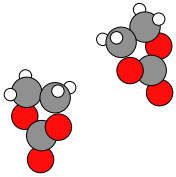

In [14]:
atoms = ase.io.read(test_file[0])
ase.io.write('2EC.png', atoms)
Image("2EC.png")

In [15]:
calc = GPRCalculator(calculator=train_data.calculator, train_data=train_data)
print(train_data.calculator)

In [16]:
atoms.calc = calc

In [22]:
print("GRP energy uncertainty:", atoms.calc.results["unc_energy"])
print("GPR energy prediction:", atoms.get_potential_energy())
print("Reference DFT energy:", test_data.energy)

GRP energy uncertainty: 0.07234211463854164
GPR energy prediction: -18641.67774058367
Reference DFT energy: [-18641.65902604]


In [23]:
print("GRP forces uncertainty:", atoms.calc.results["unc_forces"])
print("GPR forces prediction:", atoms.get_forces())
print("Reference DFT forces:", test_data.force)

GRP forces uncertainty: [[0.35674919 0.34365853 0.34796464]
 [0.35100182 0.35398961 0.36177561]
 [0.37029151 0.36002796 0.35894671]
 [0.3610305  0.362226   0.36218445]
 [0.35298989 0.35292971 0.36347916]
 [0.35890328 0.35403057 0.35904941]
 [0.35848862 0.35739019 0.35201382]
 [0.352288   0.3614165  0.35275573]
 [0.35761182 0.35700735 0.34747343]
 [0.35835402 0.35901351 0.36587618]
 [0.363937   0.35301396 0.35135912]
 [0.35817974 0.35867106 0.36231923]
 [0.35127075 0.36353156 0.36847963]
 [0.34235525 0.35242639 0.36581677]
 [0.35430557 0.35950369 0.37477568]
 [0.36241999 0.35550091 0.35965832]
 [0.35928272 0.35037062 0.34827887]
 [0.35327733 0.36489894 0.35458167]
 [0.35124861 0.36508466 0.35708147]
 [0.35852378 0.35069379 0.35808588]]
GPR forces prediction: [[ 1.00012041e-03 -2.54693188e-01  1.10455203e+00]
 [-8.53005710e-01  2.25341493e+00  1.05743886e+00]
 [-1.04507738e+00  5.07967545e+00  1.57570889e+00]
 [-1.14947176e+00  1.51978091e+00 -2.93948651e+00]
 [ 4.48503273e-01 -1.1432946